# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [45]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [46]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [47]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [48]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [49]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [50]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [51]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [52]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [53]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [54]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [55]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 63196)

In [56]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 63196)

In [57]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.2129 - loss: 4.9798 - val_accuracy: 0.5037 - val_loss: 1.7259
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3773 - loss: 3.2526 - val_accuracy: 0.5326 - val_loss: 1.6603
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4444 - loss: 2.6602 - val_accuracy: 0.5733 - val_loss: 1.5626
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4897 - loss: 2.2710 - val_accuracy: 0.6148 - val_loss: 1.5078
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5404 - loss: 1.9744 - val_accuracy: 0.6252 - val_loss: 1.3333
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5702 - loss: 1.7742 - val_accuracy: 0.6133 - val_loss: 1.4008
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6042 - loss: 1.5854 - val_accuracy: 0.6289 - val_loss: 1.3033
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6208 - loss: 1.4891 - val_ac

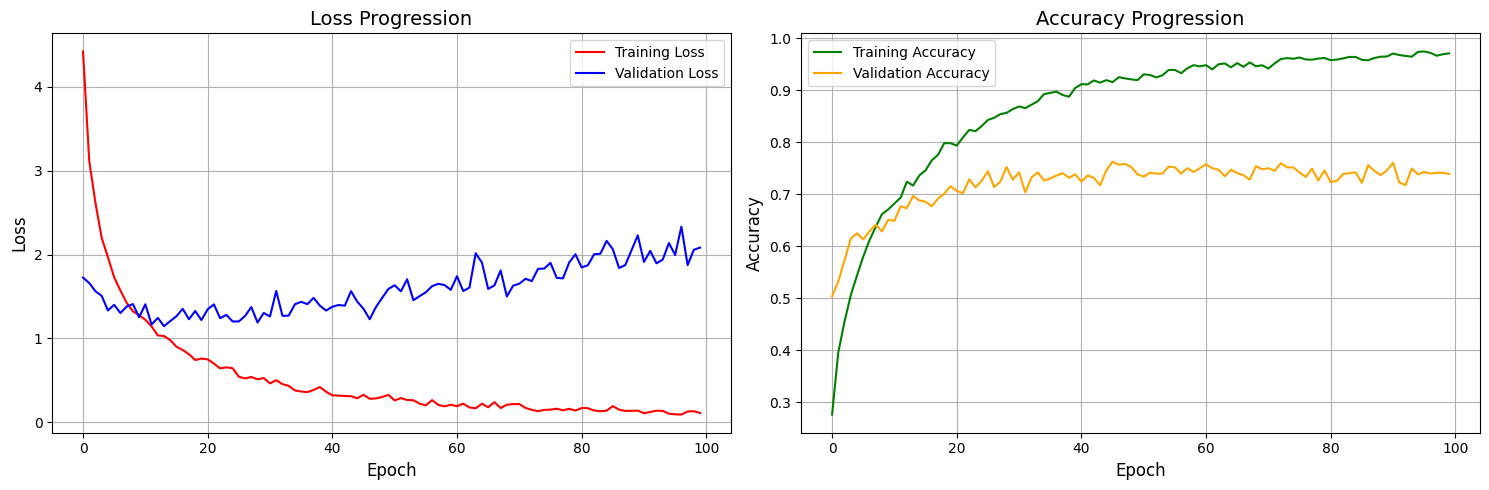

In [58]:
visualize(history, 'all_features')

In [59]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0013
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7505 - loss: 2.1586


In [60]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       114
           1       0.63      0.65      0.64       141
           2       0.86      0.74      0.79       271
           3       0.90      1.00      0.95        90
           4       0.83      0.56      0.67        18
           5       0.89      0.53      0.67        15
           6       0.25      0.61      0.35        23
           7       0.98      1.00      0.99        44
           8       0.68      0.56      0.62        50
           9       0.84      0.94      0.88        49
          10       0.92      0.75      0.83        48
          11       0.53      0.63      0.57        46
          12       0.85      0.83      0.84        54
          13       0.78      0.67      0.72        48
          14       0.50      0.84      0.63        38
          15       0.62      0.43      0.51       117
          16       1.00      0.96      0.98   

### Mel Spectrogram and Chroma

In [61]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 36260)

In [62]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 36260)

In [63]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

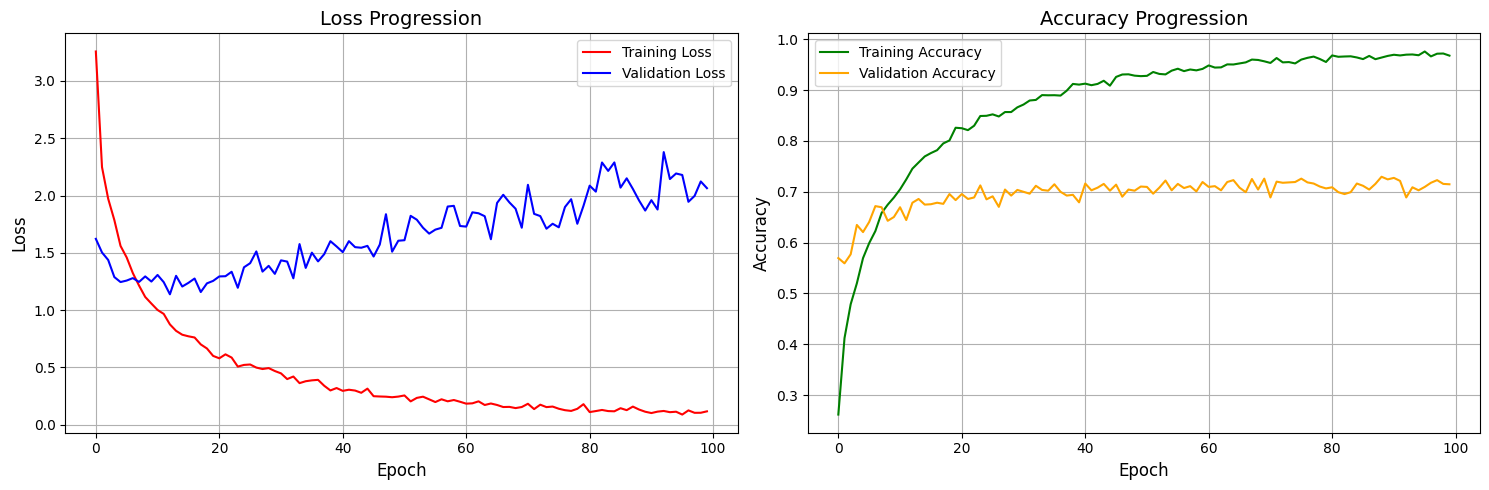

In [64]:
visualize(history, 'melspectrogram_chroma')

In [65]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9993 - loss: 0.0026
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7238 - loss: 1.9352


In [66]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.84      0.70      0.77       114
           1       0.49      0.50      0.49       141
           2       0.76      0.73      0.74       271
           3       0.85      1.00      0.92        90
           4       0.62      0.56      0.59        18
           5       0.46      0.40      0.43        15
           6       0.23      0.30      0.26        23
           7       1.00      0.95      0.98        44
           8       0.61      0.86      0.72        50
           9       0.92      0.90      0.91        49
          10       0.88      0.75      0.81        48
          11       0.67      0.52      0.59        46
          12       0.73      0.74      0.73        54
          13       0.54      0.77      0.63        48
          14       0.68      0.79      0.73        38
          15       0.56      0.43      0.48       117
          16       0.98      0.98      0.98   

### With Mel Spectrogram, MFCCs and Chroma

In [67]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 41440)

In [68]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 41440)

In [69]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

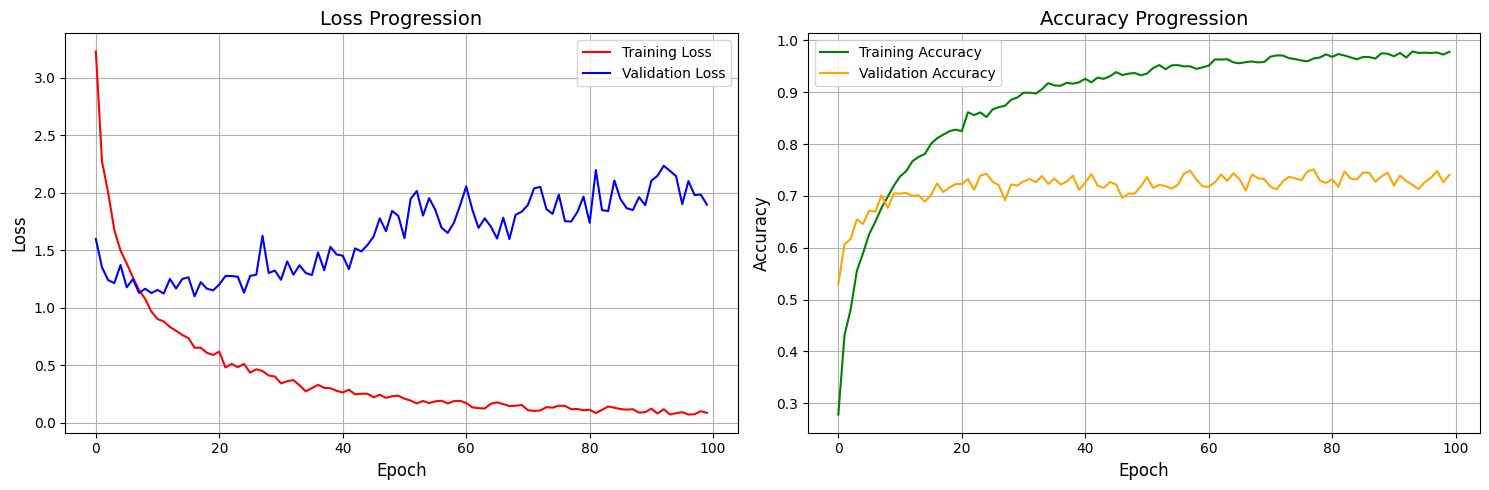

In [70]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [71]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 8.2995e-04
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 1.8764


In [72]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.78      0.68      0.73       114
           1       0.57      0.55      0.56       141
           2       0.79      0.81      0.80       271
           3       0.85      1.00      0.92        90
           4       0.92      0.67      0.77        18
           5       0.83      0.67      0.74        15
           6       0.29      0.35      0.31        23
           7       1.00      0.95      0.98        44
           8       0.58      0.68      0.62        50
           9       0.85      0.94      0.89        49
          10       0.85      0.81      0.83        48
          11       0.85      0.48      0.61        46
          12       0.73      0.76      0.75        54
          13       0.48      0.79      0.60        48
          14       0.82      0.87      0.85        38
          15       0.59      0.45      0.51       117
          16       0.92      0.98      0.95   

### With Mel Spectrogram and MFCCs

In [73]:
training_features_3D = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 38332)

In [74]:
validation_features_3D = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 38332)

In [75]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

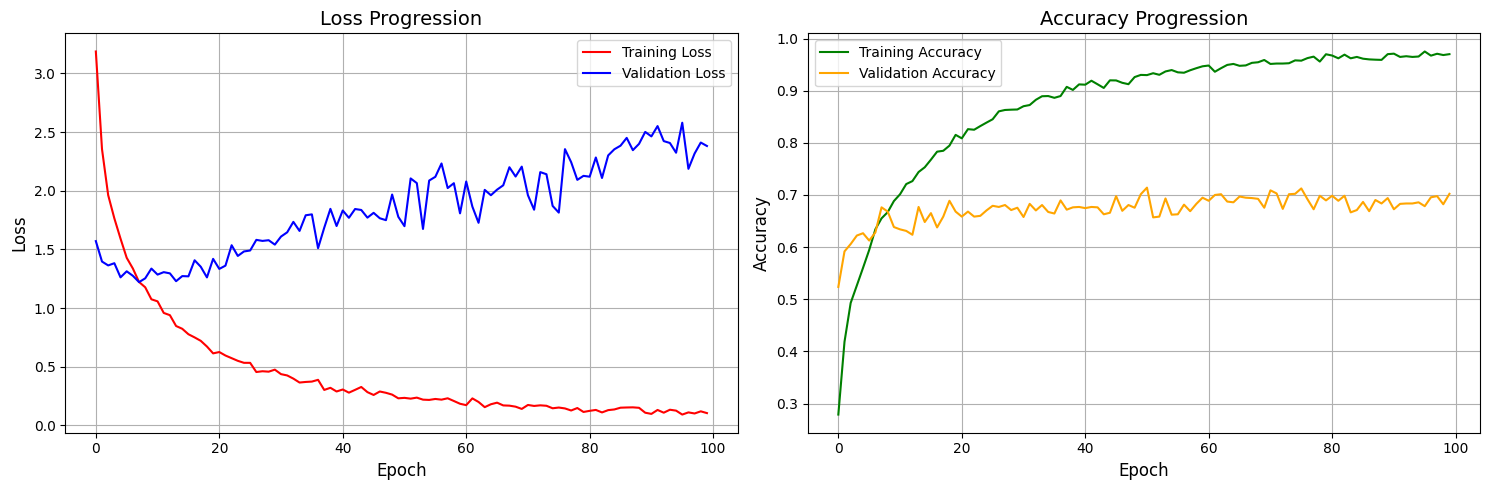

In [76]:
visualize(history, 'mfcc_melspectrogram')

In [77]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7000 - loss: 2.5010


In [78]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.69      0.75      0.71       114
           1       0.54      0.57      0.56       141
           2       0.78      0.70      0.74       271
           3       0.91      1.00      0.95        90
           4       0.46      0.33      0.39        18
           5       0.50      0.60      0.55        15
           6       0.30      0.52      0.38        23
           7       1.00      0.93      0.96        44
           8       0.72      0.68      0.70        50
           9       0.82      0.96      0.89        49
          10       0.80      0.50      0.62        48
          11       0.41      0.15      0.22        46
          12       0.77      0.74      0.75        54
          13       0.40      0.79      0.53        48
          14       0.62      0.79      0.70        38
          15       0.62      0.40      0.49       117
          16       1.00      0.98      0.99   

### With Mel Spectrogram

In [79]:
training_features_3D =  train_features['melspectrogram']
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 33152)

In [80]:
validation_features_3D = val_features['melspectrogram']
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 33152)

In [81]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

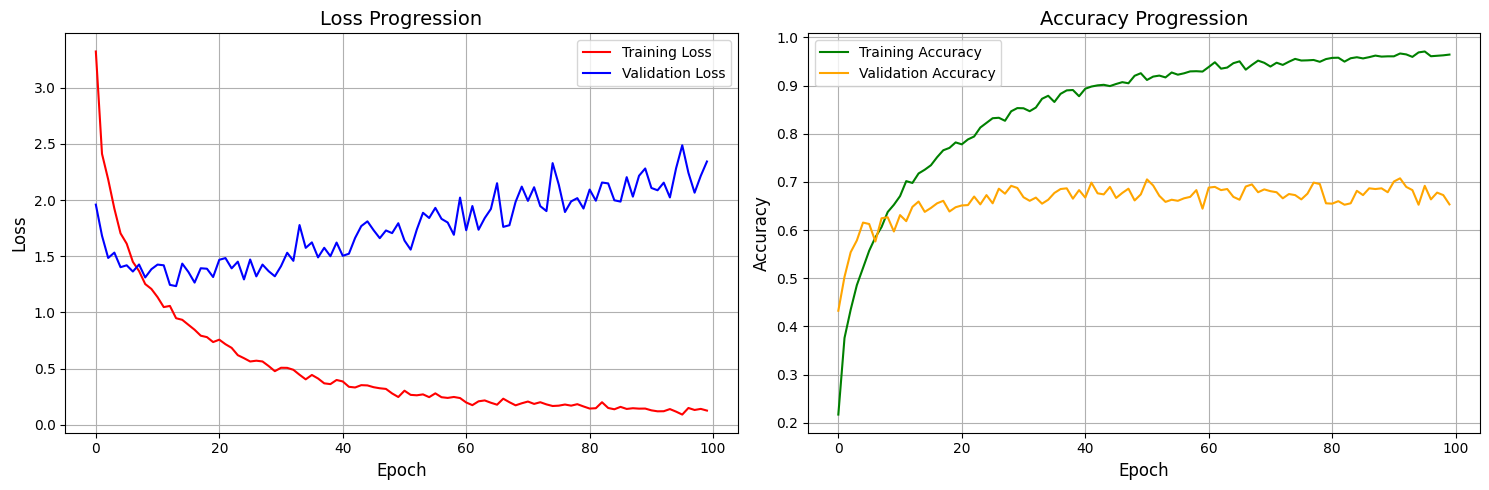

In [82]:
visualize(history, 'melspectrogram')

In [83]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9981 - loss: 0.0105
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6536 - loss: 2.3324


In [84]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       114
           1       0.44      0.37      0.40       141
           2       0.70      0.68      0.69       271
           3       0.82      1.00      0.90        90
           4       1.00      0.50      0.67        18
           5       0.32      0.47      0.38        15
           6       0.31      0.35      0.33        23
           7       1.00      0.91      0.95        44
           8       0.72      0.52      0.60        50
           9       0.86      0.88      0.87        49
          10       0.85      0.60      0.71        48
          11       0.39      0.24      0.30        46
          12       0.73      0.76      0.75        54
          13       0.49      0.85      0.62        48
          14       0.54      0.82      0.65        38
          15       0.48      0.47      0.48       117
          16       0.79      1.00      0.88   

## Review all the results

In [85]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.000,0.739
4,melspectrogram,0.998,0.653
1,melspectrogram_chroma,0.999,0.715
2,melspectrogram_chroma_mfcc,1.000,0.741
3,mfcc_melspectrogram,1.000,0.702


In [86]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.744      0.957
4              melspectrogram     0.649      0.933
1       melspectrogram_chroma     0.714      0.948
2  melspectrogram_chroma_mfcc     0.739      0.958
3         mfcc_melspectrogram     0.697      0.945
